# Assignment Brief: Probabilistic Programming and Active Learning

## Deadline: May 7, 2025, 17:00 GMT

## Number of marks available: 50

This coursework is made of two parts. In the first part, you will use probabilistic programming to perform Bayesian inference in different models. In the second part, you will use uncertainty to guide datapoint selection to create a dataset to train a machine learning model.

### Please READ the whole assignment first, before starting to work on it.

### How and what to submit

A. A **Jupyter Notebook** with the code in all the cells executed and outputs displayed.

B. Name your Notebook **COM64102_Assignment_XXXXXX.ipynb** where XXXXXX is your username such as such as abc18de. Example: `COM64102_Assignment_abc18de.ipynb`

C. Upload the Jupyter Notebook in B to Blackboard under the submission area before the deadline.

D. **NO DATA UPLOAD**: Please do not upload the data files used in this Notebook. We have a copy already.


### Assessment Criteria

* Being able to compute the posterior distribution in Bayesian logistic regression using a probabilistic program.

* Being able to compute several acquisition functions useful for active learning.

* Being able to use active learning to speed-up the training process of a digit classifier.


### Code quality and use of Python libraries
When writing your code, you will find out that there are operations that are repeated at least twice. If your code is unreadable, we may not award marks for that section. Make sure to check the following:

* Did you include Python functions to solve the question and avoid repeating code?
* Did you comment your code to make it readable to others?

### Late submissions

We follow Department's guidelines about late submissions, i.e., a deduction of 10% of the mark each 24 hours the work is late after the deadline. NO late submission will be marked one week after the deadline.

### Use of unfair means

**Any form of unfair means is treated as a serious academic offence and action may be taken under the Discipline Regulations.** Please carefully read [what constitutes Unfair Means](https://documents.manchester.ac.uk/display.aspx?DocID=2870) if not sure. If you still have questions, please ask your Personal tutor or the Lecturers.

# 1. Probabilistic Programming with PyMC

[PyMC](https://www.pymc.io/) is a powerful Python library for **Bayesian statistical modeling** and **probabilistic machine learning**. It provides an intuitive and flexible way to define complex models using a **probabilistic programming framework**.

PyMC makes it easy to express statistical models in terms of probability distributions, and it automates the process of computing posterior distributions using state-of-the-art Markov Chain Monte Carlo (MCMC) sampling methods like:
- [**No-U-Turn Sampler (NUTS)**](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf), an efficient Hamiltonian Monte Carlo method.
- **Metropolis-Hastings** ‚ a traditional and widely-used MCMC approach.

Bayesian inference involves calculating the posterior distribution:
$$
P(\theta | X) \propto P(X | \theta)P(\theta)
$$
where:
- $P(\theta)$‚ a prior distribution (our prior belief about the parameters).
- $P(X | \theta)$‚ a likelihood of the data given the parameters.
- $P(\theta | X)$, a posterior distribution (what we want to estimate).

Computing this posterior distribution analytically can be difficult or even impossible for complex models. PyMC solves this problem by using efficient numerical sampling techniques, allowing you to approximate the posterior distribution and extract meaningful insights.

## How Does PyMC Work?
1. **Model Definition**: Define the model using PyMC probabilistic building blocks (e.g., `pm.Normal`, `pm.Bernoulli`).
2. **Sampling**: Use `pm.sample()` to draw samples from the posterior distribution.
3. **Posterior Analysis**: Analyze the posterior samples to estimate parameters, uncertainties, and credible intervals.

PyMC builds on [**Theano**](https://en.wikipedia.org/wiki/Theano_(software)), which allows it to compute gradients and perform symbolic differentiation for more efficient sampling.

## 1.1 Bayesian inference over the mean of a Gaussian using PyMC

In [Lab 1 for this module](https://colab.research.google.com/github/m-caprio/COMP64102-Reasoning-and-Learning-under-Uncertainty-Module/blob/main/New%20Lab%201.ipynb), you computed the posterior distribution over the mean of a Gaussian distribution in closed form using the fact that the Gaussian likelihood and the prior over the mean of the Gaussian likelihood are conjugate. The equation for the mean of the posterior distribution had a closed form.

As a warm up example in the use of PyMC, we will do the same example using the probabilistic programming language. Refer to [Lab 1](https://colab.research.google.com/github/m-caprio/COMP64102-Reasoning-and-Learning-under-Uncertainty-Module/blob/main/New%20Lab%201.ipynb) when reading forward.


Besides installing PyMC, we will also install the [ArViz](https://python.arviz.org/en/stable/) package, which is used for exploratory analysis of Bayesian models.

In [2]:
!pip install pymc
import pymc as pm
import arviz as az

The following code uses PyMC to obtain samples from the posterior distribution of the mean of the Gaussian

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Observed data (assumed to be generated from a Gaussian distribution)
data = np.array([3.2, 2.8, 3.6, 3.0, 3.1, 2.9, 3.3, 3.5])

# Known standard deviation of the data
sigma = 0.5

# Define the model in PyMC
with pm.Model() as model:
    # Prior for mu (mean) - assume Gaussian prior
    mu_0 = 3.0  # Prior mean
    sigma_0 = 1.0  # Prior standard deviation
    mu = pm.Normal('mu', mu=mu_0, sigma=sigma_0) # Prior

    # Likelihood for the data - assume Gaussian likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data) # Likelihood

    # Sample from the posterior distribution
    trace = pm.sample(2000, return_inferencedata=True)

# Extract posterior samples
mu_p_samples = trace.posterior['mu'].values.flatten()

# Compute posterior mean and standard deviation
mu_p = np.mean(mu_p_samples)
sigma_p = np.std(mu_p_samples)

# Print results
print(f"Posterior mean (mu_p): {mu_p:.2f}")
print(f"Posterior standard deviation (sigma_p): {sigma_p:.2f}")

Output()

Posterior mean (mu_p): 3.17
Posterior standard deviation (sigma_p): 0.18


The values for the posterior mean and posterior standard deviation when comparing the exact solution in Lab 1 and the sampling approach using PyMC are the same.

**Question 1 (5 marks)**

What is the fundamental difference between the approach to compute the mean of the posterior distribution in Lab 1 and the approach to compute the mean using PyMC.

*Solution*

In lab 1, we used basic probability rules to calculate the mean of a Gaussian distribution using closed-form formulas because the prior and likelihood were both Gaussian (They formed a conjugate pair). This gave us an exact solution.

In the above approach using PyMC, instead of solving the math ourselves, we defined the model in code and used PyMC to estimate the posterior by drawing samples using MCMC. This approach gives similar results but works even when an exact formula is not possible.


We can now plot the prior, likelihood and the posterior pdf's.

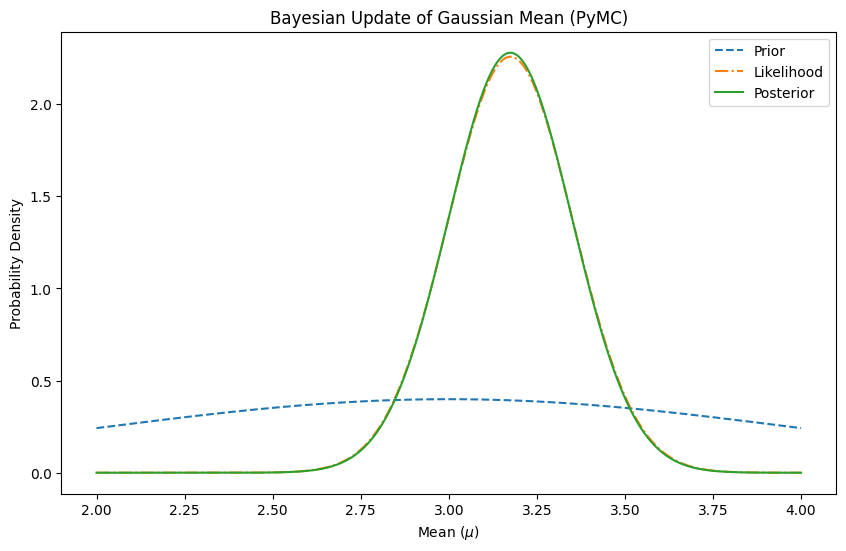

In [4]:
# Plot prior, likelihood, and posterior
x = np.linspace(2, 4, 1000)  # Range of mu values to plot
prior = norm.pdf(x, mu_0, sigma_0)  # Prior distribution
likelihood = norm.pdf(x, np.mean(data), sigma / np.sqrt(len(data)))  # Likelihood
posterior = norm.pdf(x, mu_p, sigma_p)  # Posterior distribution

plt.figure(figsize=(10, 6))
plt.plot(x, prior, label="Prior", linestyle="--")
plt.plot(x, likelihood, label="Likelihood", linestyle="-.")
plt.plot(x, posterior, label="Posterior", linestyle="-")
plt.title("Bayesian Update of Gaussian Mean (PyMC)")
plt.xlabel("Mean ($\mu$)")
plt.ylabel("Probability Density")
plt.legend()
plt.show()

Two metrics to assess convergence in MCMC are the **effective sample size** (ESS) and the **estimated potential scale reduction** (EPSRC) or **R-hat**.

We can use the [ArViz](https://python.arviz.org/en/stable/) package to compute both quantities.

In [5]:
# Posterior summary (for more detailed diagnostics)
print(az.summary(trace, var_names=["mu"], hdi_prob=0.95))

     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu  3.175  0.175     2.836      3.516      0.004    0.003    1537.0    2487.0   

    r_hat  
mu    1.0  


**Question 2 (5 marks)**

The value of `r_hat` for the mean is equal to 1.0. Explain what `r_hat` computes and whether 1.0 is a good value. Explain why it is or why it is not a good value.

*Solution*

`r_hat` (Gelman-Rubin statistic) is used to check whether the Markov Chain Monte Carlo (MCMC) sampling has converged. It compares the variance among multiple chains being sampled with the variance within each individual chain. If all the chains have converged to the same posterior (or target) distribution, their variances should be similar.

The `r_hat` value we obtained is 1.0, which means the chains are well mixed and have likely converged. This indicates that we are sampling from the same posterior distribution, as their variances are similar. If the value had been significantly greater than 1.0, it would suggest that the chains had not converged, and more sampling or better tuning would be required.

## 1.2 Bayesian logistic regression with PyMC

In the previous module in Foundations of Machine Learning, we spent some time on a linear model for classification called **logistic regression**.

In a binary classification problem, let $\mathbf{X}=[\mathbf{x}_1 \cdots \mathbf{x}_N]^\top$ and and $\mathbf{y} =[y_1\cdots y_N]^{\top}$, where $\mathbf{X}$ is the design matrix and each element in $\mathbf{y}$, say $y_n$ indicates to which class the corresponding input vector, $\mathbf{x}_n$, belongs to.

Assumming IID observations, the likelihood for the dataset is given as
\begin{align*}
p(\mathbf{y}|\mathbf{w},\mathbf{X}) = \prod_{n=1}^Np(y_n|\mathbf{w},\mathbf{x}_n)
  =\prod_{n=1}^N\textrm{Ber}(y_n|\sigma(\mathbf{w}^{\top}\mathbf{x}_n)),
\end{align*}
where $\textrm{Ber}(y_n|\mu)$ refers to the Bernoulli distribution with parameter $\mu$, and $\sigma(a)$ is the sigmoid function defined as $\sigma(a)=\frac{1}{1+ \exp(-a)}$.

The maximum-likelihood estimator for $\mathbf{w}$ can be obtained by minimising the negative log-likelihood (or the cross-entropy function) given as

\begin{align*}
NLL(\mathbf{w}) & = - \log p(\mathbf{y}|\mathbf{w},\mathbf{X}) \\
& = - \sum_{n=1}^N\{y_n\log[\sigma(\mathbf{w}^{\top}\mathbf{x}_n)] + (1-y_n)\log[1 - \sigma(\mathbf{w}^{\top}\mathbf{x}_n)] \}.
\end{align*}

In *Bayesian logistic regression*, we put a prior over the weights $\mathbf{w}$. We then compute the posterior distribution
\begin{align*}
p(\mathbf{w}|\mathbf{X}, \mathbf{y}) \propto p(\mathbf{y}|\mathbf{w}, \mathbf{X})p(\mathbf{w}).
\end{align*}
For predicting the class of a text point, $\mathbf{x}_*$, we need to compute the predictive distribution,
\begin{align}
p(y_*|\mathbf{x}_*)=\int \sigma(\mathbf{w}^{\top}\mathbf{x}_*)p(\mathbf{w}|\mathbf{X}, \mathbf{y})d\mathbf{w}.
\end{align}

If we approximate the posterior distribution $p(\mathbf{w}|\mathbf{X}, \mathbf{y})$ with a Gaussian posterior distribution,
\begin{align*}
p(\mathbf{w}|\mathbf{X}, \mathbf{y}) ≈ q(\mathbf{w}|\mathbf{X}, \mathbf{y}) = N(\mathbf{w}|𝛍_{\text{post}}, 𝚺_{\text{post}}),
\end{align*}
it can be shown the predictive distribution can also be approximated as
\begin{align*}
p(y_*=1|\mathbf{x}_*) = \sigma(\kappa (\sigma^2_a)\mu_a),
\end{align*}
where
\begin{align*}
\mu_a &= 𝛍_{\text{post}}^\top\mathbf{x}_*,\\
\sigma_a^2 &= \mathbf{x}^\top_*𝚺_{\text{post}}\mathbf{x}_*,\\
\kappa(\sigma^2) &= \frac{1}{(1+\pi \sigma^2/8)^{\frac{1}{2}}}
\end{align*}


### Bayesian logistic regression for the Iris dataset

To illustrate how Bayesian logistic regression works, we will use a very well known dataset, the [Iris dataset](https://archive.ics.uci.edu/dataset/53/iris). The dataset has three classes and four input features. We will only use two classes.

Let us load the dataset

In [6]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X3 = iris.data.features
y3 = iris.data.targets
# Drop the last class and the last two columns
Xp = X3.drop(X3.index[100:150])
yp = y3.drop(y3.index[100:150])

We now have a reduced dataset that we will split into training and test

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
# We add a vector of ones to the input space in X
X = Xp.to_numpy()
# Add a column of ones to X
y = np.vstack((np.zeros((50, 1)), np.ones((50, 1))))
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=int(1e3))
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Question 3 (10 marks)**

Let us define the following prior distribution for $\mathbf{w}$, $p(\mathbf{w})= N(\mathbf{w}|\mathbf{0}_4, 0.001\times \mathbf{I}_4)$, where $\mathbf{0}_4 = [0, 0, 0, 0]^\top$ and $\mathbf{I}_4$ is the identity matrix of dimension four since there are four input features.

Using the training data `X_train` and `y_train`, compute an approximate posterior Gaussian distribution using PyMC for a Bayesian logistic regression model. Use 2000 samples for the sampler and report the mean and the covariance matrix for the approximate Gaussian using the last 1000 samples of one of the chains (**7 marks**)

*Solution*

In [8]:
# y_train has to be flattened since PyMC expects the ovserved data in a flat form
# for bernoulli LL
y_train_flat = y_train.flatten()

# defining the prior mean and covariance for the weights
mean_prior = np.zeros(4)
cov_prior = 0.001 * np.eye(4)

with pm.Model() as logistic_model:
    # setting a multivariate normal prior over weights
    w = pm.MvNormal("w", mu=mean_prior, cov=cov_prior)

    # computing the linear combination of features and weights
    logit = pm.math.dot(X_train, w)

    # defining the likelihood using the Bernoulli distribution with logit link
    # this is why we had to flatten y_train as mentioned above
    y_obs = pm.Bernoulli("y_obs", logit_p=logit, observed=y_train_flat)

    # To sample from the posterior using NUTS sampler
    trace = pm.sample(2000, chains=2, return_inferencedata=True, target_accept=0.9)

# Extractinh the last 1000 samples
w_posterior_samples = trace.posterior["w"].sel(chain=0).isel(draw=slice(-1000, None)).values

# Computing the mean of posterior weight samples
w_posterior_mean = np.mean(w_posterior_samples, axis=0)

# Now the covariance matrix of the posterior weight samples
w_posterior_cov = np.cov(w_posterior_samples, rowvar=False)

print("Posterior mean of weights:\n", w_posterior_mean)
print("\nPosterior covariance matrix:\n", w_posterior_cov)

Output()

Posterior mean of weights:
 [ 0.01834582 -0.01966661  0.02884734  0.02690247]

Posterior covariance matrix:
 [[ 1.05067981e-03 -2.25289292e-05 -6.93879989e-05 -3.12113021e-05]
 [-2.25289292e-05  9.30330461e-04  2.99362107e-05 -2.46905702e-06]
 [-6.93879989e-05  2.99362107e-05  1.07531348e-03 -2.35356307e-05]
 [-3.12113021e-05 -2.46905702e-06 -2.35356307e-05  9.99418874e-04]]


Compute the accuracy of the linear classifier over the test set using the approximated distribution $p(y_*=1|\mathbf{x}_*) = \sigma(\kappa (\sigma^2_a)\mu_a)$, as explained above (**3 marks**).

*Solution*

In [9]:
from scipy.special import expit

# computing the linear predictor using the posterior mean
mu_a = X_test @ w_posterior_mean
temp = X_test @ w_posterior_cov

# computing the variance of the linear predictor for each test sample
sigma_a2 = np.sum(temp * X_test, axis=1)

# computing Kappa to adjust the predictive mean based on the formula given above
k_sigma_a2 = 1.0 / np.sqrt(1.0 + (np.pi * sigma_a2) / 8.0)

# computing the predicted probability using the scaled linear predictor
pred_prob = expit(k_sigma_a2 * mu_a)

# converting predicted probabilities to class labels (threshold = 0.5)
y_pred = (pred_prob >= 0.5).astype(int).flatten()

# computing accuracy by comparing predictions to true labels
accuracy = np.mean(y_pred == y_test.flatten())

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


# 2. Active Learning -- Using data selection via uncertainty to keep models fresh

We can use
uncertainties to figure out whether data should be part of the training data
or not. We can expand on this idea in the context of an area of
machine learning called **active learning**. The promise of active
learning is that a model can learn more eﬀectively on less data if we
have a way to control the type of data it is trained on. Active learning is a way to
guide the learning process and data a model is trained on by
**providing acquisition functions** that can acquire data from a pool of data that is
not part of the training data. By iteratively selecting the right data
from the pool, we can train a model that performs better than if we
had chosen the data from the pool at random.

The active learning approach can be described with the following iterative procedure
```
A model is initially trained using a few samples per class
for iter until a fixed number of iterations:
  compute an acquisition function over the data in the pool
  based on the acquisition function select a sample to include in the  
     training data
  train the model again using the augmented training data
```

In this part of the coursework, we will use results from a fundamental
active learning paper: [Deep Bayesian Active Learning with Image Data
(2017)](https://arxiv.org/abs/1703.02910). We will use the MNIST dataset and train a model on more
and more data, where we select the data points to add to our
training set via an uncertainty method. In this case, we will use **epistemic uncertainty** to select the most informative data points.
Images with high epistemic uncertainty will be added to the traininig dataset in a sequential manner. The epistemic uncertainty can be computed using different methods. You will use **Monte Carlo dropout** and will compare the performance of using epistemic uncertainty to introduce new points in the training data against including new training points just but randomly selecting from a pool of available data.

**IMPORTANT** To reduce the amount of code appearing in the notebook, we have created a set of python modules that include auxiliary functions. You need to make sure when running the notebook that your Google Drive is mounted and the auxiliar Python files can be accessed from the Notebook. On how to allow your Notebook to find the .py files in your Google Drive, see instructions in this [link](https://nimbusintelligence.com/2023/03/import-python-scripts-in-google-colab/)

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
# The path here can be different, depending on where you have uploaded the auxiliary Python files config.py, main.py, utils.py, model.py, visualise.py, data.py
sys.path.insert(0,'/content/drive/MyDrive/Auxilary Files')

Mounted at /content/drive


We start by importing a set of modules

In [11]:
import dataclasses
from typing import Optional, Tuple, Union, Callable
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torchvision
from tqdm import tqdm
import json
from pathlib import Path
import gc
import uuid
import matplotlib.pyplot as plt

In [12]:
!pip install laplace-torch
from laplace import Laplace

## 2.1 Preparing the dataset

We work with the MNIST dataset.

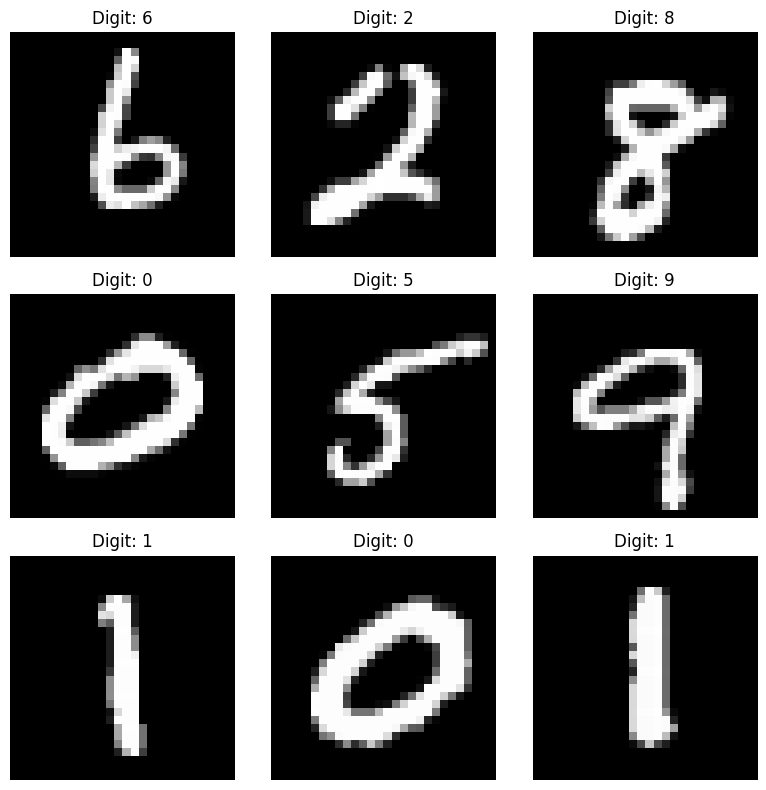

Total training samples: 60000
Total test samples: 10000


In [13]:
from data import get_data, prepare_data_loaders

# Get preprocessed MNIST data
data = get_data()

# Create PyTorch DataLoaders
train_loader, test_loader = prepare_data_loaders(data, batch_size=64)

# Function to display a grid of images
def display_mnist_samples(images, labels, grid_size=(3, 3)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(8, 8))

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Remove the extra dimension and display the image
            ax.imshow(images[i].squeeze(), cmap='gray')
            # Get the original label (not one-hot encoded)
            label = np.argmax(labels[i])
            ax.set_title(f"Digit: {label}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display a few samples from the training set
num_samples = 9
indices = np.random.choice(len(data.x_train), num_samples, replace=False)
sample_images = data.x_train[indices]
sample_labels = data.y_train[indices]

# Display the images
display_mnist_samples(sample_images, sample_labels)

# Print some information about the dataset
print(f"Total training samples: {len(data.x_train)}")
print(f"Total test samples: {len(data.x_test)}")

## 2.2 Defining the model

We can now define our model. We will use a small, simple Convolutional Neural Network with dropout as shown below:

```
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(3872, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

def build_model():
    model = MNISTModel()
    return model

```
This network model has been defined in the file `model.py` and we will call it later.

## 2.3 Defining the uncertainty functions

### 2.3.1 Epistemic or knowledge uncertainty

We will use epistemic uncertainty (also called knowledge
uncertainty) as one of our main uncertainty functions to acquire new
samples. Let us define the function to compute epistemic uncertainty
over our predictions.

We define the followoing terms and notations:
- $\omega$: Model parameters (weights and biases)
- $p(y = c|x, \omega)$: Probability of input $x$ belonging to class $c$ with model parameters $\omega$
- $q_\theta^*(\omega)$: Approximate posterior distribution over model parameters
- $\hat{\omega}_t \sim q_\theta^*(\omega)$: A sample of weights drawn from the approximate posterior
- $\hat{p}_c^t = p(y = c|x, \hat{\omega}_t)$: Predicted probability for class $c$ using sampled weights $\hat{\omega}_t$ in MC dropout
- $T$: Total number of Monte Carlo dropout forward passes
- $C$: Number of classes

### Total Uncertainty

The total predictive uncertainty is captured by the entropy of the expected predictive distribution (Max Entropy, (Shannon, 1948)):

$$H[y|x, D_{\text{train}}] = -\sum_{c} p(y = c|x, D_{\text{train}}) \log p(y = c|x, D_{\text{train}})$$

This can be approximated using $T$ forward passes with MC dropout:

$$H[y|x, D_{\text{train}}] \approx -\sum_{c} \left(\frac{1}{T}\sum_{t=1}^{T} \hat{p}_c^t\right) \log \left(\frac{1}{T}\sum_{t=1}^{T} \hat{p}_c^t\right)$$

### Data Uncertainty (Aleatoric)

Data uncertainty represents the inherent noise in the data, approximated as the expected entropy of individual predictions (Gal, 2016, pp. 48–52):

$$E_{p(\omega|D_{\text{train}})}[H[y|x, \omega]] \approx \frac{1}{T}\sum_{t=1}^{T} \left(-\sum_{c} \hat{p}_c^t \log \hat{p}_c^t\right)$$

### Knowledge Uncertainty (Epistemic)

Knowledge uncertainty is the mutual information between predictions and model posterior, which is the BALD acquisition function (Houlsby et al., 2011) in the paper (which is Total `Uncertainty` - `Data Uncertainty`) :

$$I[y, \omega|x, D_{\text{train}}] = H[y|x, D_{\text{train}}] - E_{p(\omega|D_{\text{train}})}[H[y|x, \omega]]$$

This quantity represents the uncertainty in the model parameters, which can be reduced by acquiring more data. This is why it serves as an effective acquisition function for active learning.



Knowledge uncertainty will be used as acquisition function in the active learning loop. To compute it, we first need the weights obtained through MC dropout.

`get_mc_predictions` uses MC droupout to generate the necessary prediction distribution (multiple predictions per sample) that the uncertainty functions need as input. It creates the `preds` tensor $\hat{p}_c^t$ with shape (n_samples, n_mc_passes, n_classes) that is directly passed to `total_uncertainty`, `data_uncertainty`, and `knowledge_uncertainty`. Without these stochastic samples $\hat{p}_c^t$ from dropout, we could not calculate these different uncertainty types for active learning sample selection.

In [14]:
def get_mc_predictions(model: nn.Module, n_iter: int, x_train: torch.Tensor) -> torch.Tensor:
    device = next(model.parameters()).device
    preds = []
    # Set model to training mode to enable dropout
    model.train()
    with torch.no_grad():
        for _ in tqdm(range(n_iter)):
            # Split data into batches
            preds_iter = []
            for batch in torch.chunk(x_train, chunks=6):
                batch = batch.to(device)
                # Ensure input is float and has correct shape (add channel dim if needed)
                if len(batch.shape) == 3:
                    batch = batch.unsqueeze(1)
                preds_iter.append(model(batch))
            # Concatenate batch predictions
            preds.append(torch.cat(preds_iter, dim=0))
    # Stack predictions and move axes to get (n_images, n_predictions, n_classes)
    preds = torch.stack(preds, dim=1)
    return preds

**Question 3 (10 marks)**

Write the code for the functions `data_uncertainty` and `total_uncertainty` below

*Solution*

In [15]:
def total_uncertainty(preds: torch.Tensor, epsilon: float = 1e-10) -> torch.Tensor:
    #mean over all the samples -> n_samples
    mean_preds = preds.mean(dim=1)
    # entropy calculated based on the mean of the predictive distribution preds
    entropy_mean = -torch.sum(mean_preds * torch.log(mean_preds + 1e-12), dim=1)
    return entropy_mean

def data_uncertainty(preds: torch.Tensor, epsilon: float = 1e-10) -> torch.Tensor:
    #entropy per sample+class prediction
    entropy_per_pass = -torch.sum(preds * torch.log(preds + 1e-12), dim=2)
    # average over all the passes -> n_samples
    mean_entropy = entropy_per_pass.mean(dim=1)
    return mean_entropy

def knowledge_uncertainty(preds: torch.Tensor, epsilon: float = 1e-10) -> torch.Tensor:
    # Knowledge uncertainty is the difference between total and data uncertainty
    return total_uncertainty(preds, epsilon) - data_uncertainty(preds, epsilon)

The acquisition function that uses the knowledge uncertainty function can be summarised in three steps
1. Obtain an ensemble of predictions via MC dropout (done by `get_mc_predictions`).
2. Compute the knowledge uncertainty values over this prediction
ensemble (use `knowledge_uncertainty` function).
3. Sort the uncertainty values, get their index and return the
indices of the data in the pool with the highest epistemic
uncertainty.

In [16]:
def acquire_knowledge_uncertainty(
    x_train: torch.Tensor, n_samples: int, model: nn.Module, n_iter: int, *args, **kwargs
):
    # Get Monte Carlo predictions
    preds = get_mc_predictions(model, n_iter, x_train)
    # Compute knowledge uncertainty
    ku = knowledge_uncertainty(preds)
    # Get indices of samples with highest uncertainty
    _, indices = torch.topk(ku, n_samples)
    return indices.cpu().numpy()

### 2.3.2 Laplace uncertainty

Rather than using MC dropout to compute samples on the parameters of the neural network, we can use a Laplace approximation, which approximates the posterior distribution of the parameters using a Gaussian distribution.

The predictive distribution under a Bayesian approach (Gal, 2016) can be written as:

$$p(y=c|x, D_{train}) = \int p(y=c|x, \omega)p(\omega|D_{train})d\omega.$$

With Laplace approximation, we approximate the posterior $p(\omega|D_{train})$ with a **Gaussian distribution** $N$ centered at the MAP estimate:

$$p(\omega|D_{train}) \approx N(\omega|\omega_{MAP}, \Sigma_{post}),$$

where:
- $\omega_{MAP}$ is the maximum a posteriori estimate of the parameters
- $\Sigma_{post}$ is the covariance matrix computed at $\omega_{MAP}$.

We can then use this posterior distribution and the probit likelihood to approximate the posterior probabilities over the classes.

Computing the Laplace approximation for a posterior distribution of a neural network is cumbersome in general. Here, we use a recent package known as [Laplace that allows to compute the posterior distribution effortlessly](https://github.com/AlexImmer/Laplace).

### Uncertainty Measure for Acquisition when using the Laplace approximation

We use Max Entropy (Shannon, 1948) as an uncertainty measure in this case:

$$H[y|x, D_{train}] := -\sum_{c} p(y=c|x, D_{train}) \log p(y=c|x, D_{train})$$

This acquisition function selects pool points that maximize the predictive entropy.

The acquisition function that uses the max entropy with Laplace approximation can be summarised in three steps
1. Obtain the predictions under the posterior distribution via Laplace approximation.
2. Compute the max entropy values for the datapoints in the pool.
3. Sort the uncertainty values, get their index and return the
indices of the data in the pool with the highest epistemic
uncertainty.

**Question 4 (10 marks)**

The following acquisition function implements the three steps above. Write the code for steps 1 and 2.

*Solution*

In [17]:
def acquire_laplace_uncertainty(
    unlabeled_tensor: torch.Tensor, n_samples: int, la_model: Laplace) -> np.ndarray:
    try:
        # Step 1: Predict probabilities with error handling
        #
        with torch.no_grad():
          preds = la_model.predictive_samples(unlabeled_tensor, n_samples=20).mean(0)
        # Convert to numpy with checks
        try:
            preds_np = preds.numpy()
        except Exception:
            preds_np = preds.detach().cpu().numpy()

        # Step 2: Entropy calculation
        #
        #
        uncertainty = -np.sum(preds_np * np.log(preds_np + 1e-10), axis=1)

        # Step 3: Select indices with highest uncertainty
        indices = np.argsort(uncertainty)[-n_samples:]
        return indices

    except Exception as e:
        print(f"Laplace Acquisition Error: {e}")
        # Fallback to random sampling
        return np.random.choice(len(unlabeled_tensor), n_samples, replace=False)

### 2.3.3 Random selection

The simplest approach to select a datapoint from the pool is to do it randomly

In [18]:
def acquire_random(x_train: torch.Tensor, n_samples: int, *args, **kwargs) -> np.ndarray:
    # Randomly select samples
    return torch.randperm(len(x_train))[:n_samples].numpy()

### 2.3.4 A battery of acquisition functions

We can group the three acquisition functions above in a function,

In [19]:
def acquisition_factory(acquisition_type: str) -> Callable:
    if acquisition_type == "laplace_uncertainty":
        return acquire_laplace_uncertainty
    if acquisition_type == "knowledge_uncertainty":
        return acquire_knowledge_uncertainty
    elif acquisition_type == "random":
        return acquire_random
    else:
        raise ValueError(f"Acquisition type {acquisition_type} not supported")

Now that we have defined our acquisition functions, we are ready
to define the loop that runs the active learning iterations.

## 2.4 Main Loop for Active Learning

We will start our dataset with 20 samples until we reach a total of 500 samples. Each model will be trained for 25 epochs and per iteration, we acquire 10 samples. To obtain our MC dropout predictions, we will run over
our full training set (minus the already acquired samples) 48 times.

It will take you approx. 1 hour to finish the active learning loop using standard colab T4 GPU.

In [20]:
import main
main.acquisition_factory= acquisition_factory #Put your acquisition functions inside the main module
from main import Active_learning

In [21]:
# Run Active Learning on Laplace Uncertainty Acquisition
accuracies_l, added_indices_l = Active_learning(
    acquisition_type="laplace_uncertainty",
    n_epochs=50,
    n_samples_per_iter=10,
    initial_n_samples=20,
    n_total_samples=500,
    use_wandb=False
)

# Run Active Learning on Random Acquisition
accuracies_r, added_indices_r = Active_learning(
    acquisition_type="random",
    n_epochs=50,
    n_samples_per_iter=10,
    initial_n_samples=20,
    n_total_samples=500,
    use_wandb=False
)

# Run Active Learning on Knowlege Uncertainty Acquisition
accuracies_k, added_indices_k = Active_learning(
   acquisition_type="knowledge_uncertainty",
    n_epochs=50,
    n_samples_per_iter=10,
    initial_n_samples=20,
    n_total_samples=500,
    use_wandb=False
)

Using device: cuda
Model directory: models/laplace_uncertainty/f7789abe-0415-45f2-a15a-91fda02df7fc
Laplace_Uncertainty Iteration 1/48
Epoch 1/50 - Loss: 2.3015 - Acc: 0.1000 - Val Loss: 2.2977 - Val Acc: 0.1132
Epoch 25/50 - Loss: 0.1132 - Acc: 0.9500 - Val Loss: 1.8751 - Val Acc: 0.5047
Epoch 50/50 - Loss: 0.0022 - Acc: 1.0000 - Val Loss: 2.6890 - Val Acc: 0.4927
Laplace approximation fitted
Iteration 1: Added 10 samples - Accuracy: 49.27%
Laplace_Uncertainty Iteration 2/48
Epoch 1/50 - Loss: 2.3171 - Acc: 0.0667 - Val Loss: 2.3004 - Val Acc: 0.0982
Epoch 25/50 - Loss: 0.1966 - Acc: 1.0000 - Val Loss: 1.6235 - Val Acc: 0.5559
Epoch 50/50 - Loss: 0.0550 - Acc: 0.9667 - Val Loss: 2.2641 - Val Acc: 0.5441
Laplace approximation fitted
Iteration 2: Added 10 samples - Accuracy: 54.41%
Laplace_Uncertainty Iteration 3/48
Epoch 1/50 - Loss: 2.3107 - Acc: 0.0500 - Val Loss: 2.2997 - Val Acc: 0.1009
Epoch 25/50 - Loss: 0.3317 - Acc: 0.9000 - Val Loss: 1.3215 - Val Acc: 0.5917
Epoch 50/50 - Loss

100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 1: Added 10 samples - Accuracy: 59.08%
Knowledge_Uncertainty Iteration 2/48
Epoch 1/50 - Loss: 2.2946 - Acc: 0.1333 - Val Loss: 2.2858 - Val Acc: 0.1449
Epoch 25/50 - Loss: 0.0617 - Acc: 1.0000 - Val Loss: 1.1098 - Val Acc: 0.6768
Epoch 50/50 - Loss: 0.0059 - Acc: 1.0000 - Val Loss: 1.5390 - Val Acc: 0.6824


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 2: Added 10 samples - Accuracy: 68.24%
Knowledge_Uncertainty Iteration 3/48
Epoch 1/50 - Loss: 2.3243 - Acc: 0.0750 - Val Loss: 2.2895 - Val Acc: 0.1032
Epoch 25/50 - Loss: 0.0653 - Acc: 1.0000 - Val Loss: 1.1690 - Val Acc: 0.6797
Epoch 50/50 - Loss: 0.0239 - Acc: 1.0000 - Val Loss: 1.1492 - Val Acc: 0.7422


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 3: Added 10 samples - Accuracy: 74.22%
Knowledge_Uncertainty Iteration 4/48
Epoch 1/50 - Loss: 2.2974 - Acc: 0.2000 - Val Loss: 2.2762 - Val Acc: 0.1434
Epoch 25/50 - Loss: 0.1769 - Acc: 0.9600 - Val Loss: 1.0364 - Val Acc: 0.7247
Epoch 50/50 - Loss: 0.0334 - Acc: 1.0000 - Val Loss: 1.2335 - Val Acc: 0.7495


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Iteration 4: Added 10 samples - Accuracy: 74.95%
Knowledge_Uncertainty Iteration 5/48
Epoch 1/50 - Loss: 2.3108 - Acc: 0.0833 - Val Loss: 2.2708 - Val Acc: 0.2165
Epoch 25/50 - Loss: 0.1979 - Acc: 0.9167 - Val Loss: 0.8826 - Val Acc: 0.7576
Epoch 50/50 - Loss: 0.0168 - Acc: 1.0000 - Val Loss: 1.1159 - Val Acc: 0.7613


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Iteration 5: Added 10 samples - Accuracy: 76.13%
Knowledge_Uncertainty Iteration 6/48
Epoch 1/50 - Loss: 2.3112 - Acc: 0.1429 - Val Loss: 2.2725 - Val Acc: 0.1769
Epoch 25/50 - Loss: 0.1564 - Acc: 0.9429 - Val Loss: 1.0383 - Val Acc: 0.7276
Epoch 50/50 - Loss: 0.0133 - Acc: 1.0000 - Val Loss: 1.2100 - Val Acc: 0.7597


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 6: Added 10 samples - Accuracy: 75.97%
Knowledge_Uncertainty Iteration 7/48
Epoch 1/50 - Loss: 2.3118 - Acc: 0.1500 - Val Loss: 2.2723 - Val Acc: 0.2547
Epoch 25/50 - Loss: 0.0511 - Acc: 0.9875 - Val Loss: 0.9004 - Val Acc: 0.7810
Epoch 50/50 - Loss: 0.0308 - Acc: 0.9875 - Val Loss: 0.9627 - Val Acc: 0.7987


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 7: Added 10 samples - Accuracy: 79.87%
Knowledge_Uncertainty Iteration 8/48
Epoch 1/50 - Loss: 2.3182 - Acc: 0.1222 - Val Loss: 2.2738 - Val Acc: 0.1818
Epoch 25/50 - Loss: 0.0880 - Acc: 0.9667 - Val Loss: 0.8786 - Val Acc: 0.7762
Epoch 50/50 - Loss: 0.0404 - Acc: 1.0000 - Val Loss: 1.1418 - Val Acc: 0.7852


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 8: Added 10 samples - Accuracy: 78.52%
Knowledge_Uncertainty Iteration 9/48
Epoch 1/50 - Loss: 2.3197 - Acc: 0.0600 - Val Loss: 2.2726 - Val Acc: 0.0980
Epoch 25/50 - Loss: 0.1193 - Acc: 0.9500 - Val Loss: 0.9451 - Val Acc: 0.7852
Epoch 50/50 - Loss: 0.0446 - Acc: 0.9800 - Val Loss: 1.3000 - Val Acc: 0.7660


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Iteration 9: Added 10 samples - Accuracy: 76.60%
Knowledge_Uncertainty Iteration 10/48
Epoch 1/50 - Loss: 2.2992 - Acc: 0.1636 - Val Loss: 2.2559 - Val Acc: 0.2479
Epoch 25/50 - Loss: 0.0852 - Acc: 0.9818 - Val Loss: 1.0031 - Val Acc: 0.7858
Epoch 50/50 - Loss: 0.0352 - Acc: 0.9909 - Val Loss: 1.1379 - Val Acc: 0.7826


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 10: Added 10 samples - Accuracy: 78.26%
Knowledge_Uncertainty Iteration 11/48
Epoch 1/50 - Loss: 2.2706 - Acc: 0.1833 - Val Loss: 2.1880 - Val Acc: 0.2591
Epoch 25/50 - Loss: 0.0377 - Acc: 0.9750 - Val Loss: 1.0077 - Val Acc: 0.7842
Epoch 50/50 - Loss: 0.0198 - Acc: 0.9917 - Val Loss: 1.1379 - Val Acc: 0.7958


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 11: Added 10 samples - Accuracy: 79.58%
Knowledge_Uncertainty Iteration 12/48
Epoch 1/50 - Loss: 2.2862 - Acc: 0.1692 - Val Loss: 2.2024 - Val Acc: 0.2629
Epoch 25/50 - Loss: 0.0831 - Acc: 0.9846 - Val Loss: 1.0100 - Val Acc: 0.7790
Epoch 50/50 - Loss: 0.0145 - Acc: 1.0000 - Val Loss: 1.3230 - Val Acc: 0.7722


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 12: Added 10 samples - Accuracy: 77.22%
Knowledge_Uncertainty Iteration 13/48
Epoch 1/50 - Loss: 2.3023 - Acc: 0.1214 - Val Loss: 2.2595 - Val Acc: 0.1015
Epoch 25/50 - Loss: 0.0480 - Acc: 0.9857 - Val Loss: 0.9045 - Val Acc: 0.7902
Epoch 50/50 - Loss: 0.0236 - Acc: 1.0000 - Val Loss: 1.1671 - Val Acc: 0.8085


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 13: Added 10 samples - Accuracy: 80.85%
Knowledge_Uncertainty Iteration 14/48
Epoch 1/50 - Loss: 2.2770 - Acc: 0.1733 - Val Loss: 2.2306 - Val Acc: 0.2108
Epoch 25/50 - Loss: 0.0464 - Acc: 0.9933 - Val Loss: 1.0599 - Val Acc: 0.7641
Epoch 50/50 - Loss: 0.0112 - Acc: 1.0000 - Val Loss: 1.2387 - Val Acc: 0.7985


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Iteration 14: Added 10 samples - Accuracy: 79.85%
Knowledge_Uncertainty Iteration 15/48
Epoch 1/50 - Loss: 2.2791 - Acc: 0.1562 - Val Loss: 2.2237 - Val Acc: 0.2166
Epoch 25/50 - Loss: 0.0565 - Acc: 0.9938 - Val Loss: 1.0113 - Val Acc: 0.8067
Epoch 50/50 - Loss: 0.0216 - Acc: 0.9938 - Val Loss: 1.1140 - Val Acc: 0.8233


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 15: Added 10 samples - Accuracy: 82.33%
Knowledge_Uncertainty Iteration 16/48
Epoch 1/50 - Loss: 2.2846 - Acc: 0.1765 - Val Loss: 2.1677 - Val Acc: 0.4085
Epoch 25/50 - Loss: 0.0592 - Acc: 0.9941 - Val Loss: 0.6888 - Val Acc: 0.8317
Epoch 50/50 - Loss: 0.0188 - Acc: 0.9941 - Val Loss: 0.9772 - Val Acc: 0.8323


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 16: Added 10 samples - Accuracy: 83.23%
Knowledge_Uncertainty Iteration 17/48
Epoch 1/50 - Loss: 2.2230 - Acc: 0.2000 - Val Loss: 2.1037 - Val Acc: 0.3681
Epoch 25/50 - Loss: 0.0324 - Acc: 0.9833 - Val Loss: 1.0313 - Val Acc: 0.8052
Epoch 50/50 - Loss: 0.0119 - Acc: 1.0000 - Val Loss: 0.8712 - Val Acc: 0.8334


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 17: Added 10 samples - Accuracy: 83.34%
Knowledge_Uncertainty Iteration 18/48
Epoch 1/50 - Loss: 2.2745 - Acc: 0.1684 - Val Loss: 2.1698 - Val Acc: 0.4094
Epoch 25/50 - Loss: 0.0519 - Acc: 0.9842 - Val Loss: 0.8592 - Val Acc: 0.8283
Epoch 50/50 - Loss: 0.0698 - Acc: 0.9842 - Val Loss: 0.9281 - Val Acc: 0.8394


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 18: Added 10 samples - Accuracy: 83.94%
Knowledge_Uncertainty Iteration 19/48
Epoch 1/50 - Loss: 2.2554 - Acc: 0.1500 - Val Loss: 2.1330 - Val Acc: 0.3922
Epoch 25/50 - Loss: 0.0846 - Acc: 0.9700 - Val Loss: 0.8830 - Val Acc: 0.8259
Epoch 50/50 - Loss: 0.0376 - Acc: 0.9900 - Val Loss: 0.8739 - Val Acc: 0.8407


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 19: Added 10 samples - Accuracy: 84.07%
Knowledge_Uncertainty Iteration 20/48
Epoch 1/50 - Loss: 2.2931 - Acc: 0.1190 - Val Loss: 2.1971 - Val Acc: 0.2835
Epoch 25/50 - Loss: 0.0277 - Acc: 0.9952 - Val Loss: 0.9823 - Val Acc: 0.8231
Epoch 50/50 - Loss: 0.0080 - Acc: 0.9952 - Val Loss: 0.8949 - Val Acc: 0.8475


100%|██████████| 20/20 [00:06<00:00,  3.27it/s]


Iteration 20: Added 10 samples - Accuracy: 84.75%
Knowledge_Uncertainty Iteration 21/48
Epoch 1/50 - Loss: 2.2786 - Acc: 0.1682 - Val Loss: 2.1662 - Val Acc: 0.3992
Epoch 25/50 - Loss: 0.0669 - Acc: 0.9818 - Val Loss: 0.7458 - Val Acc: 0.8414
Epoch 50/50 - Loss: 0.0276 - Acc: 0.9909 - Val Loss: 0.7563 - Val Acc: 0.8479


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 21: Added 10 samples - Accuracy: 84.79%
Knowledge_Uncertainty Iteration 22/48
Epoch 1/50 - Loss: 2.2265 - Acc: 0.2000 - Val Loss: 1.9661 - Val Acc: 0.5210
Epoch 25/50 - Loss: 0.0486 - Acc: 0.9870 - Val Loss: 0.7846 - Val Acc: 0.8296
Epoch 50/50 - Loss: 0.0311 - Acc: 0.9870 - Val Loss: 0.7482 - Val Acc: 0.8462


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Iteration 22: Added 10 samples - Accuracy: 84.62%
Knowledge_Uncertainty Iteration 23/48
Epoch 1/50 - Loss: 2.2330 - Acc: 0.2083 - Val Loss: 2.0545 - Val Acc: 0.2824
Epoch 25/50 - Loss: 0.0371 - Acc: 0.9875 - Val Loss: 0.7441 - Val Acc: 0.8538
Epoch 50/50 - Loss: 0.0274 - Acc: 0.9917 - Val Loss: 0.8410 - Val Acc: 0.8559


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 23: Added 10 samples - Accuracy: 85.59%
Knowledge_Uncertainty Iteration 24/48
Epoch 1/50 - Loss: 2.2530 - Acc: 0.2120 - Val Loss: 2.1044 - Val Acc: 0.5757
Epoch 25/50 - Loss: 0.0381 - Acc: 0.9920 - Val Loss: 0.6349 - Val Acc: 0.8568
Epoch 50/50 - Loss: 0.0228 - Acc: 0.9880 - Val Loss: 0.8188 - Val Acc: 0.8643


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 24: Added 10 samples - Accuracy: 86.43%
Knowledge_Uncertainty Iteration 25/48
Epoch 1/50 - Loss: 2.2447 - Acc: 0.1923 - Val Loss: 2.0497 - Val Acc: 0.4545
Epoch 25/50 - Loss: 0.0532 - Acc: 0.9923 - Val Loss: 0.6726 - Val Acc: 0.8543
Epoch 50/50 - Loss: 0.0198 - Acc: 0.9923 - Val Loss: 0.9261 - Val Acc: 0.8470


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 25: Added 10 samples - Accuracy: 84.70%
Knowledge_Uncertainty Iteration 26/48
Epoch 1/50 - Loss: 2.2708 - Acc: 0.1815 - Val Loss: 2.1248 - Val Acc: 0.4316
Epoch 25/50 - Loss: 0.0526 - Acc: 0.9889 - Val Loss: 0.6771 - Val Acc: 0.8549
Epoch 50/50 - Loss: 0.0207 - Acc: 0.9963 - Val Loss: 0.7839 - Val Acc: 0.8676


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 26: Added 10 samples - Accuracy: 86.76%
Knowledge_Uncertainty Iteration 27/48
Epoch 1/50 - Loss: 2.2169 - Acc: 0.2679 - Val Loss: 1.9924 - Val Acc: 0.5602
Epoch 25/50 - Loss: 0.1015 - Acc: 0.9571 - Val Loss: 0.5633 - Val Acc: 0.8629
Epoch 50/50 - Loss: 0.0210 - Acc: 0.9929 - Val Loss: 0.6842 - Val Acc: 0.8735


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 27: Added 10 samples - Accuracy: 87.35%
Knowledge_Uncertainty Iteration 28/48
Epoch 1/50 - Loss: 2.2379 - Acc: 0.2034 - Val Loss: 2.0488 - Val Acc: 0.4479
Epoch 25/50 - Loss: 0.0573 - Acc: 0.9828 - Val Loss: 0.6785 - Val Acc: 0.8537
Epoch 50/50 - Loss: 0.0398 - Acc: 0.9931 - Val Loss: 0.5632 - Val Acc: 0.8788


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Iteration 28: Added 10 samples - Accuracy: 87.88%
Knowledge_Uncertainty Iteration 29/48
Epoch 1/50 - Loss: 2.2570 - Acc: 0.1767 - Val Loss: 2.1178 - Val Acc: 0.2585
Epoch 25/50 - Loss: 0.0478 - Acc: 0.9833 - Val Loss: 0.5842 - Val Acc: 0.8670
Epoch 50/50 - Loss: 0.0283 - Acc: 0.9867 - Val Loss: 0.7462 - Val Acc: 0.8716


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 29: Added 10 samples - Accuracy: 87.16%
Knowledge_Uncertainty Iteration 30/48
Epoch 1/50 - Loss: 2.1615 - Acc: 0.2258 - Val Loss: 1.7188 - Val Acc: 0.5881
Epoch 25/50 - Loss: 0.0534 - Acc: 0.9839 - Val Loss: 0.6457 - Val Acc: 0.8613
Epoch 50/50 - Loss: 0.0158 - Acc: 0.9935 - Val Loss: 0.7184 - Val Acc: 0.8809


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 30: Added 10 samples - Accuracy: 88.09%
Knowledge_Uncertainty Iteration 31/48
Epoch 1/50 - Loss: 2.2016 - Acc: 0.2469 - Val Loss: 1.9666 - Val Acc: 0.4614
Epoch 25/50 - Loss: 0.0413 - Acc: 0.9875 - Val Loss: 0.5795 - Val Acc: 0.8775
Epoch 50/50 - Loss: 0.0502 - Acc: 0.9875 - Val Loss: 0.6257 - Val Acc: 0.8816


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 31: Added 10 samples - Accuracy: 88.16%
Knowledge_Uncertainty Iteration 32/48
Epoch 1/50 - Loss: 2.2121 - Acc: 0.2455 - Val Loss: 1.9810 - Val Acc: 0.4959
Epoch 25/50 - Loss: 0.0415 - Acc: 0.9879 - Val Loss: 0.8667 - Val Acc: 0.8458
Epoch 50/50 - Loss: 0.0079 - Acc: 1.0000 - Val Loss: 0.9050 - Val Acc: 0.8682


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 32: Added 10 samples - Accuracy: 86.82%
Knowledge_Uncertainty Iteration 33/48
Epoch 1/50 - Loss: 2.2296 - Acc: 0.2353 - Val Loss: 1.9883 - Val Acc: 0.5268
Epoch 25/50 - Loss: 0.0735 - Acc: 0.9824 - Val Loss: 0.6411 - Val Acc: 0.8675
Epoch 50/50 - Loss: 0.0284 - Acc: 0.9882 - Val Loss: 0.6492 - Val Acc: 0.8847


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Iteration 33: Added 10 samples - Accuracy: 88.47%
Knowledge_Uncertainty Iteration 34/48
Epoch 1/50 - Loss: 2.1894 - Acc: 0.2600 - Val Loss: 1.9209 - Val Acc: 0.3902
Epoch 25/50 - Loss: 0.0718 - Acc: 0.9771 - Val Loss: 0.6211 - Val Acc: 0.8693
Epoch 50/50 - Loss: 0.0157 - Acc: 0.9943 - Val Loss: 0.6382 - Val Acc: 0.8857


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 34: Added 10 samples - Accuracy: 88.57%
Knowledge_Uncertainty Iteration 35/48
Epoch 1/50 - Loss: 2.1936 - Acc: 0.2889 - Val Loss: 1.7771 - Val Acc: 0.6142
Epoch 25/50 - Loss: 0.0384 - Acc: 0.9889 - Val Loss: 0.5683 - Val Acc: 0.8787
Epoch 50/50 - Loss: 0.0396 - Acc: 0.9806 - Val Loss: 0.6068 - Val Acc: 0.8925


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 35: Added 10 samples - Accuracy: 89.25%
Knowledge_Uncertainty Iteration 36/48
Epoch 1/50 - Loss: 2.1209 - Acc: 0.3108 - Val Loss: 1.6317 - Val Acc: 0.5894
Epoch 25/50 - Loss: 0.0543 - Acc: 0.9838 - Val Loss: 0.5207 - Val Acc: 0.8800
Epoch 50/50 - Loss: 0.0081 - Acc: 0.9973 - Val Loss: 0.7221 - Val Acc: 0.8880


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 36: Added 10 samples - Accuracy: 88.80%
Knowledge_Uncertainty Iteration 37/48
Epoch 1/50 - Loss: 2.1758 - Acc: 0.2947 - Val Loss: 1.8304 - Val Acc: 0.5141
Epoch 25/50 - Loss: 0.0446 - Acc: 0.9789 - Val Loss: 0.5059 - Val Acc: 0.8887
Epoch 50/50 - Loss: 0.0106 - Acc: 0.9974 - Val Loss: 0.6193 - Val Acc: 0.8912


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 37: Added 10 samples - Accuracy: 89.12%
Knowledge_Uncertainty Iteration 38/48
Epoch 1/50 - Loss: 2.0935 - Acc: 0.2872 - Val Loss: 1.4793 - Val Acc: 0.6848
Epoch 25/50 - Loss: 0.0217 - Acc: 0.9923 - Val Loss: 0.5457 - Val Acc: 0.8884
Epoch 50/50 - Loss: 0.0226 - Acc: 0.9897 - Val Loss: 0.5876 - Val Acc: 0.8961


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 38: Added 10 samples - Accuracy: 89.61%
Knowledge_Uncertainty Iteration 39/48
Epoch 1/50 - Loss: 2.1295 - Acc: 0.2725 - Val Loss: 1.6114 - Val Acc: 0.5730
Epoch 25/50 - Loss: 0.0516 - Acc: 0.9750 - Val Loss: 0.5351 - Val Acc: 0.8802
Epoch 50/50 - Loss: 0.0080 - Acc: 1.0000 - Val Loss: 0.5419 - Val Acc: 0.9031


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Iteration 39: Added 10 samples - Accuracy: 90.31%
Knowledge_Uncertainty Iteration 40/48
Epoch 1/50 - Loss: 2.0781 - Acc: 0.2976 - Val Loss: 1.5631 - Val Acc: 0.5995
Epoch 25/50 - Loss: 0.0306 - Acc: 0.9902 - Val Loss: 0.4502 - Val Acc: 0.8959
Epoch 50/50 - Loss: 0.0151 - Acc: 0.9976 - Val Loss: 0.5412 - Val Acc: 0.9061


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 40: Added 10 samples - Accuracy: 90.61%
Knowledge_Uncertainty Iteration 41/48
Epoch 1/50 - Loss: 2.1178 - Acc: 0.2905 - Val Loss: 1.5794 - Val Acc: 0.6065
Epoch 25/50 - Loss: 0.0231 - Acc: 0.9952 - Val Loss: 0.5289 - Val Acc: 0.8939
Epoch 50/50 - Loss: 0.0113 - Acc: 0.9976 - Val Loss: 0.5293 - Val Acc: 0.9022


100%|██████████| 20/20 [00:06<00:00,  3.29it/s]


Iteration 41: Added 10 samples - Accuracy: 90.22%
Knowledge_Uncertainty Iteration 42/48
Epoch 1/50 - Loss: 1.9387 - Acc: 0.3651 - Val Loss: 1.1889 - Val Acc: 0.6657
Epoch 25/50 - Loss: 0.0333 - Acc: 0.9907 - Val Loss: 0.4246 - Val Acc: 0.8988
Epoch 50/50 - Loss: 0.0165 - Acc: 0.9953 - Val Loss: 0.4964 - Val Acc: 0.9003


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Iteration 42: Added 10 samples - Accuracy: 90.03%
Knowledge_Uncertainty Iteration 43/48
Epoch 1/50 - Loss: 2.1226 - Acc: 0.2614 - Val Loss: 1.6716 - Val Acc: 0.5263
Epoch 25/50 - Loss: 0.0473 - Acc: 0.9841 - Val Loss: 0.5284 - Val Acc: 0.8905
Epoch 50/50 - Loss: 0.0288 - Acc: 0.9932 - Val Loss: 0.6065 - Val Acc: 0.8928


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Iteration 43: Added 10 samples - Accuracy: 89.28%
Knowledge_Uncertainty Iteration 44/48
Epoch 1/50 - Loss: 2.1673 - Acc: 0.2289 - Val Loss: 1.7311 - Val Acc: 0.5652
Epoch 25/50 - Loss: 0.0186 - Acc: 0.9978 - Val Loss: 0.5444 - Val Acc: 0.8900
Epoch 50/50 - Loss: 0.0300 - Acc: 0.9911 - Val Loss: 0.5080 - Val Acc: 0.8974


100%|██████████| 20/20 [00:06<00:00,  3.28it/s]


Iteration 44: Added 10 samples - Accuracy: 89.74%
Knowledge_Uncertainty Iteration 45/48
Epoch 1/50 - Loss: 2.0057 - Acc: 0.3043 - Val Loss: 1.3238 - Val Acc: 0.6276
Epoch 25/50 - Loss: 0.0316 - Acc: 0.9891 - Val Loss: 0.4693 - Val Acc: 0.8987
Epoch 50/50 - Loss: 0.0220 - Acc: 0.9913 - Val Loss: 0.4932 - Val Acc: 0.9097


100%|██████████| 20/20 [00:06<00:00,  3.31it/s]


Iteration 45: Added 10 samples - Accuracy: 90.97%
Knowledge_Uncertainty Iteration 46/48
Epoch 1/50 - Loss: 2.0384 - Acc: 0.3553 - Val Loss: 1.3279 - Val Acc: 0.6379
Epoch 25/50 - Loss: 0.0295 - Acc: 0.9872 - Val Loss: 0.4670 - Val Acc: 0.9055
Epoch 50/50 - Loss: 0.0340 - Acc: 0.9936 - Val Loss: 0.4335 - Val Acc: 0.9190


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Iteration 46: Added 10 samples - Accuracy: 91.90%
Knowledge_Uncertainty Iteration 47/48
Epoch 1/50 - Loss: 1.9377 - Acc: 0.3250 - Val Loss: 1.2184 - Val Acc: 0.6855
Epoch 25/50 - Loss: 0.0505 - Acc: 0.9833 - Val Loss: 0.4169 - Val Acc: 0.9109
Epoch 50/50 - Loss: 0.0246 - Acc: 0.9958 - Val Loss: 0.4084 - Val Acc: 0.9183


100%|██████████| 20/20 [00:06<00:00,  3.32it/s]


Iteration 47: Added 10 samples - Accuracy: 91.83%
Knowledge_Uncertainty Iteration 48/48
Epoch 1/50 - Loss: 1.9863 - Acc: 0.3490 - Val Loss: 1.3632 - Val Acc: 0.5673
Epoch 25/50 - Loss: 0.0399 - Acc: 0.9857 - Val Loss: 0.4452 - Val Acc: 0.9007
Epoch 50/50 - Loss: 0.0222 - Acc: 0.9898 - Val Loss: 0.5092 - Val Acc: 0.9138


100%|██████████| 20/20 [00:06<00:00,  3.30it/s]


Iteration 48: Added 10 samples - Accuracy: 91.38%

===== Completed knowledge_uncertainty acquisition =====



### 2.5  Visualise the Results

Now that we have our loop, we can inspect the results of this
process. We will use seaborn and matplotlib to visualize our
results. The main result we are interested in is the test accuracy over time
for both the models trained with a random acquisition function and
the models trained with data acquired via knowledge uncertainty.
To visualize this, we define `ActiveLearningVisualizer` that loads the results and
then returns a plot that shows the accuracy per active learning
iteration cycle.

We can then use this function to plot the results for all acquisition
functions:

Results saved in output


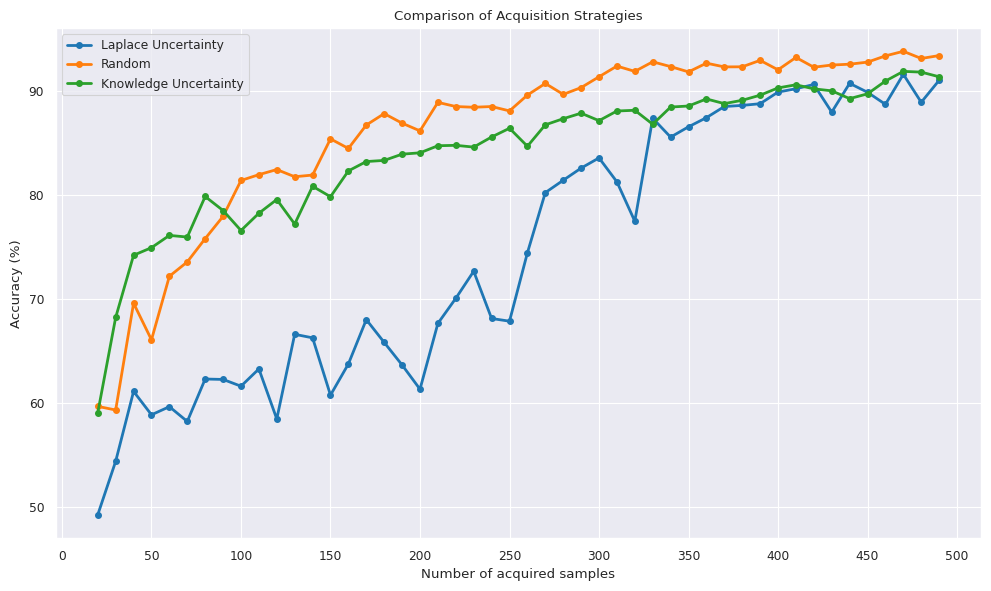

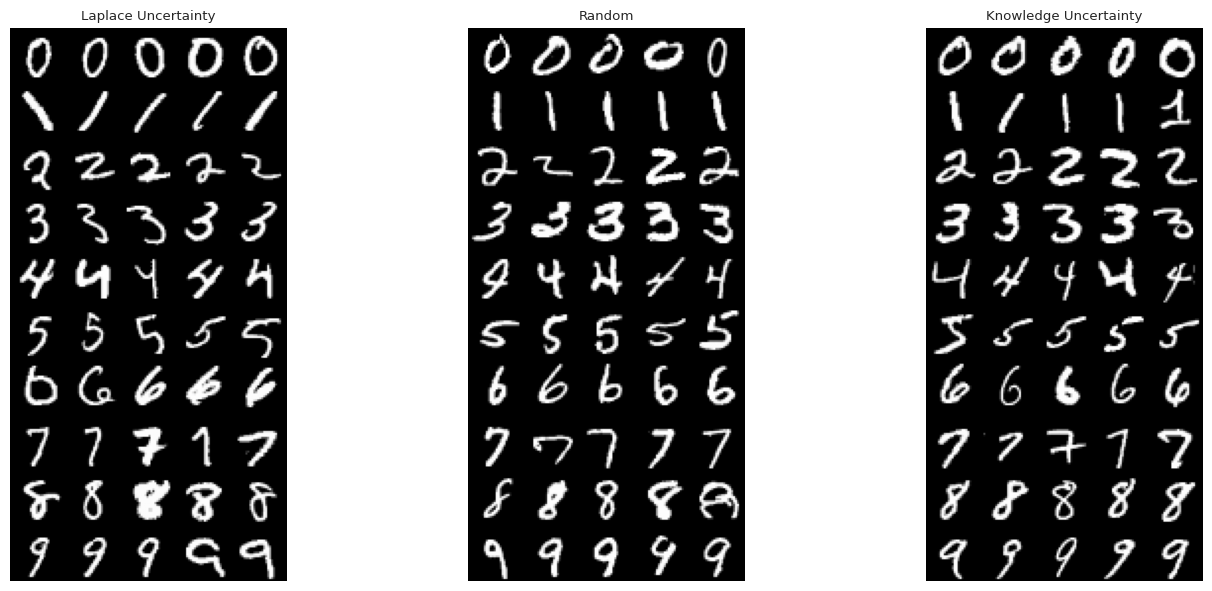

In [25]:
from visualise import ActiveLearningVisualizer
import matplotlib.pyplot as plt

# Initialize visualizer
visualizer = ActiveLearningVisualizer(output_dir="output", samples_per_iter=10, initial_samples=20)

# Compare different acquisition strategies
# IMPORTANT: change the uuids according to the ones assigned to each of the models trained
fig_acc, fig_img, imgs = visualizer.compare_from_uuids(
    uuids=["f7789abe-0415-45f2-a15a-91fda02df7fc",
            "d2c501b4-8779-411f-80f1-583a98b0c9a6",
            "eb3168ef-1e78-4782-82bc-fe61572340b0"],
    acquisition_types=["laplace_uncertainty", "random", "knowledge_uncertainty"]
)

plt.show()

**Question 5 (10 marks)**

- What can you conclude from the figure that shows the Accuracy of the different acquisition strategies? (**5 marks**). Use a single sentence.

*Solution*

The Random acquisition strategy achieves the highest final accuracy (93.42%) compared to Laplace Uncertainty (91.04%) and Knowledge Uncertainty (91.38%).

- What can you conclude when comparing the samples of the digits chosen for training by the different Acquisition strategies? (**5 marks**). Use a single sentence.

*Solution*

The Random strategy likely selects a more balanced and effective set of samples, leading to better model performance than uncertainty-based approaches.
